# Data augmentation graphs input and output

in this code the augmented data for the chemistry data challange is made.

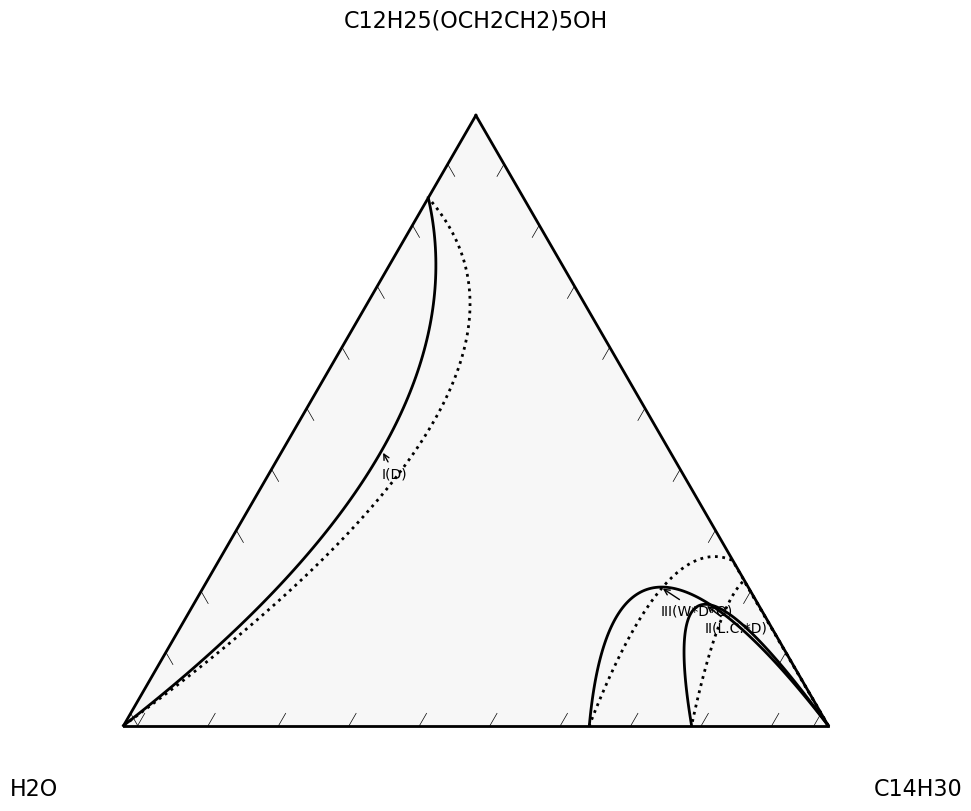

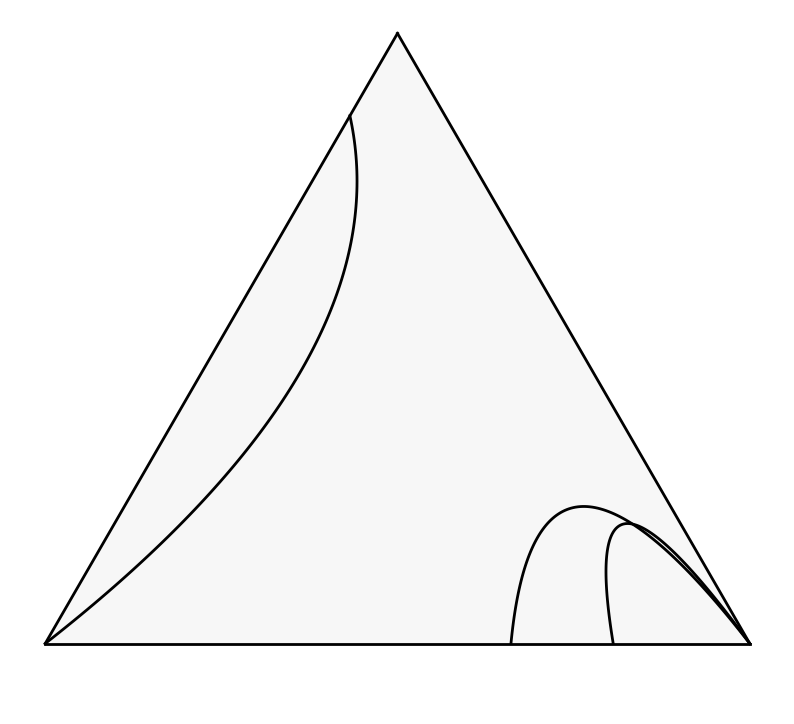

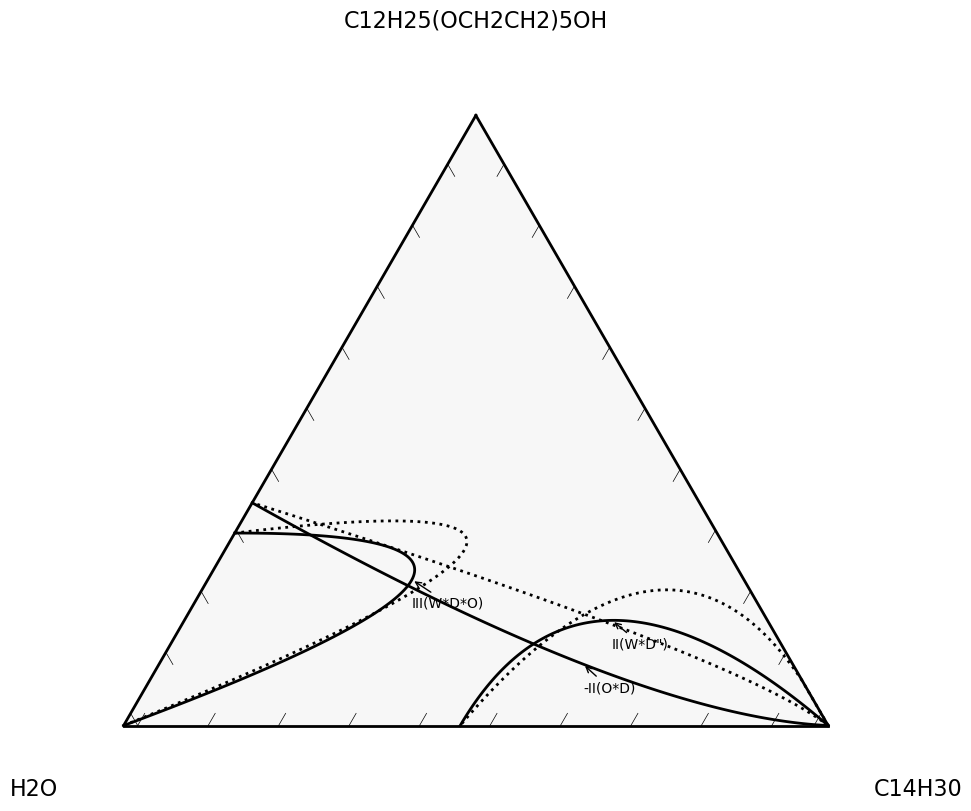

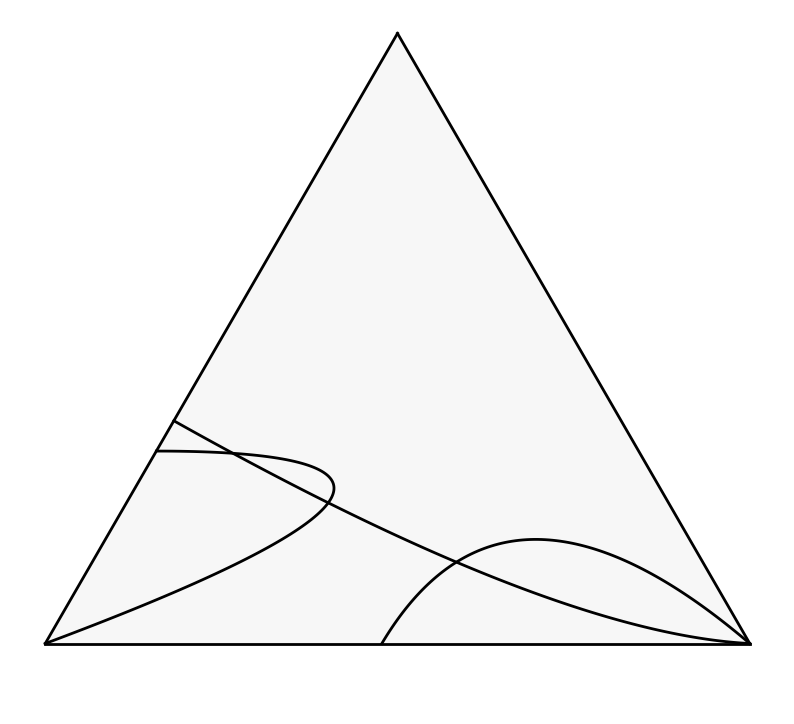

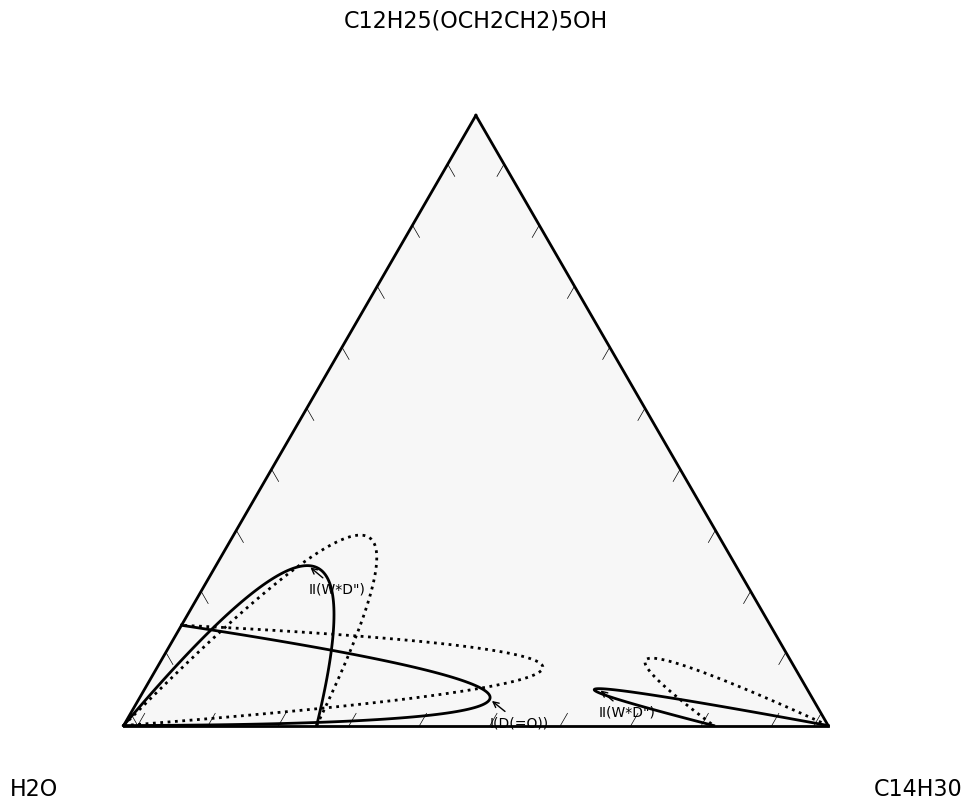

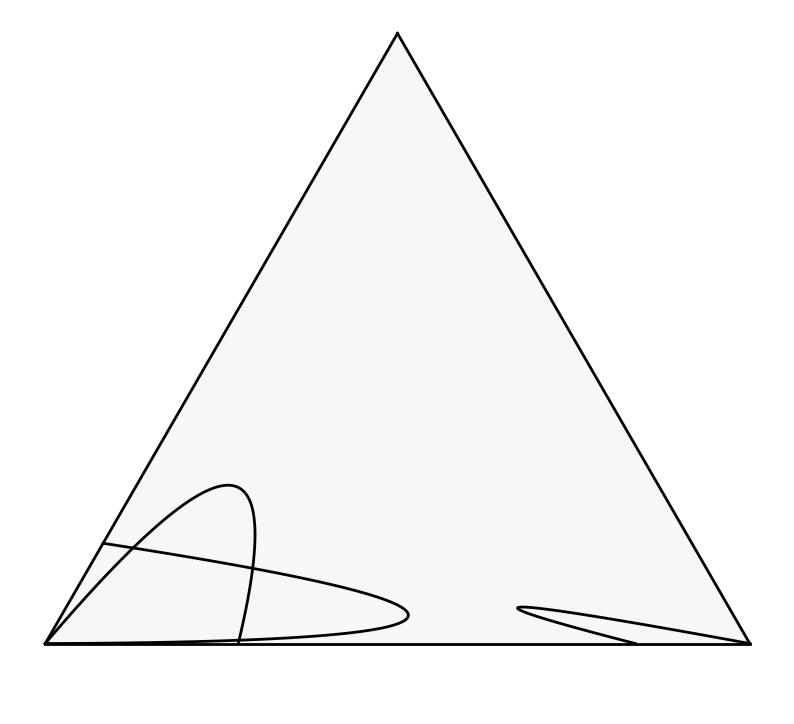

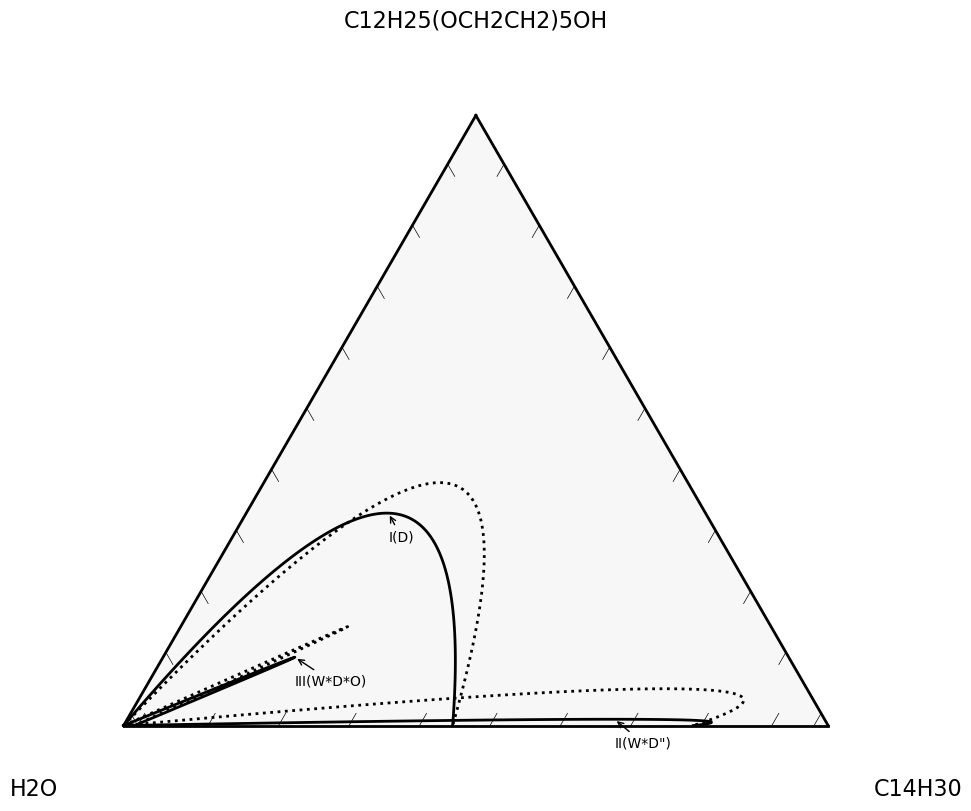

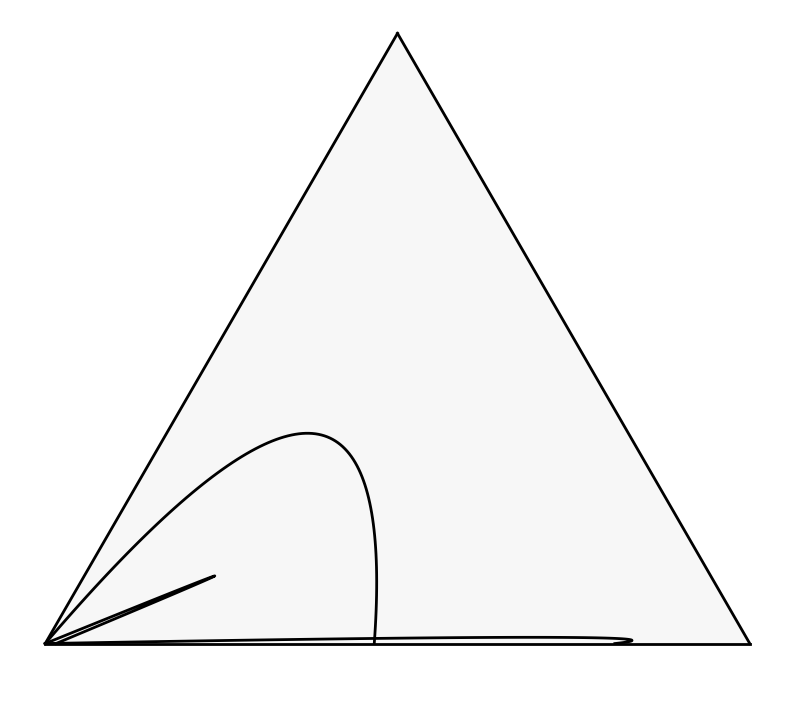

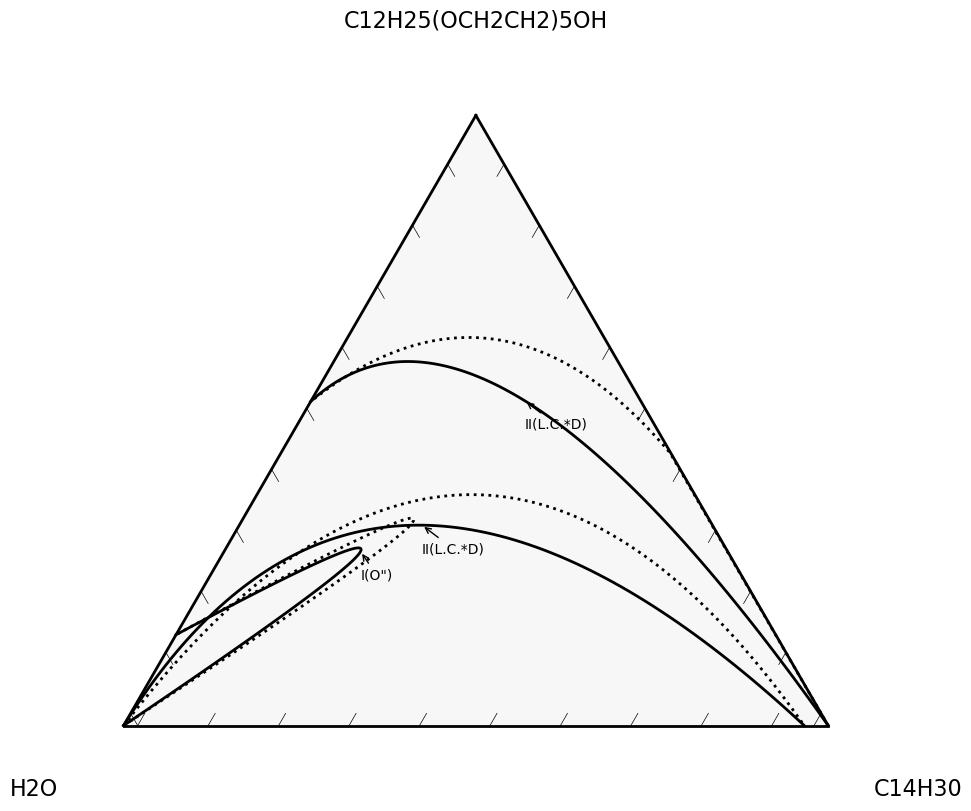

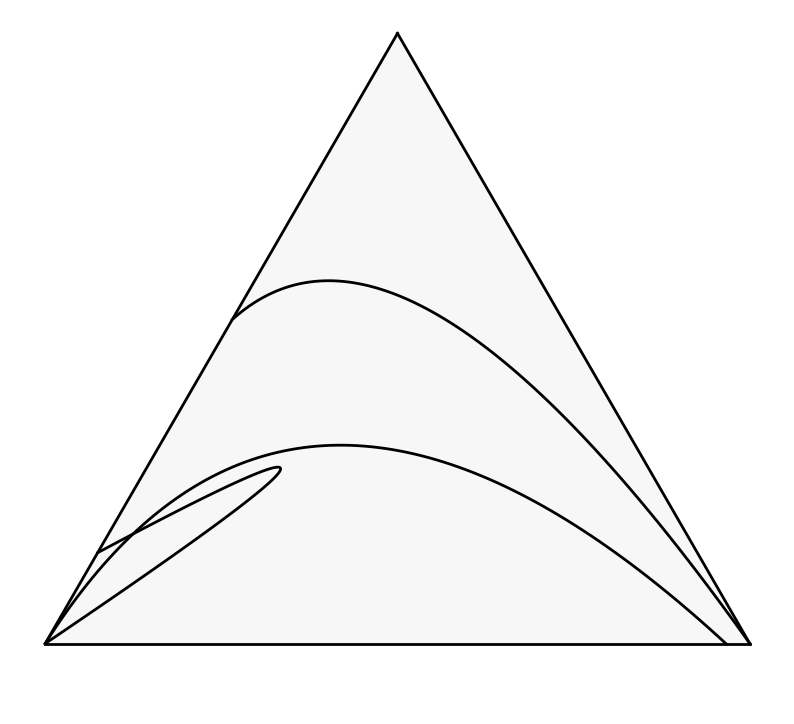

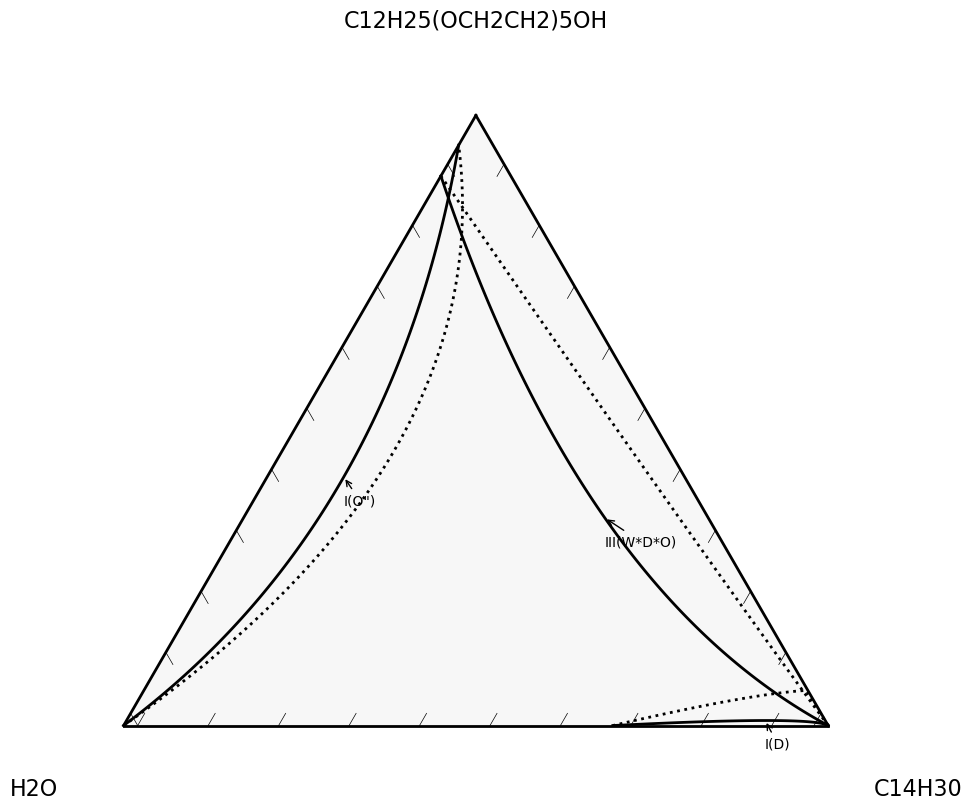

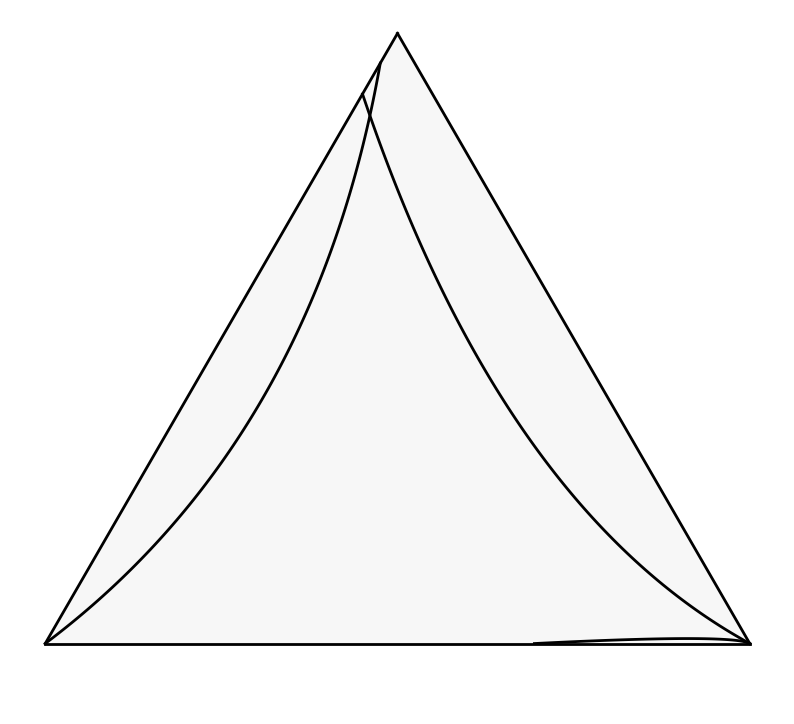

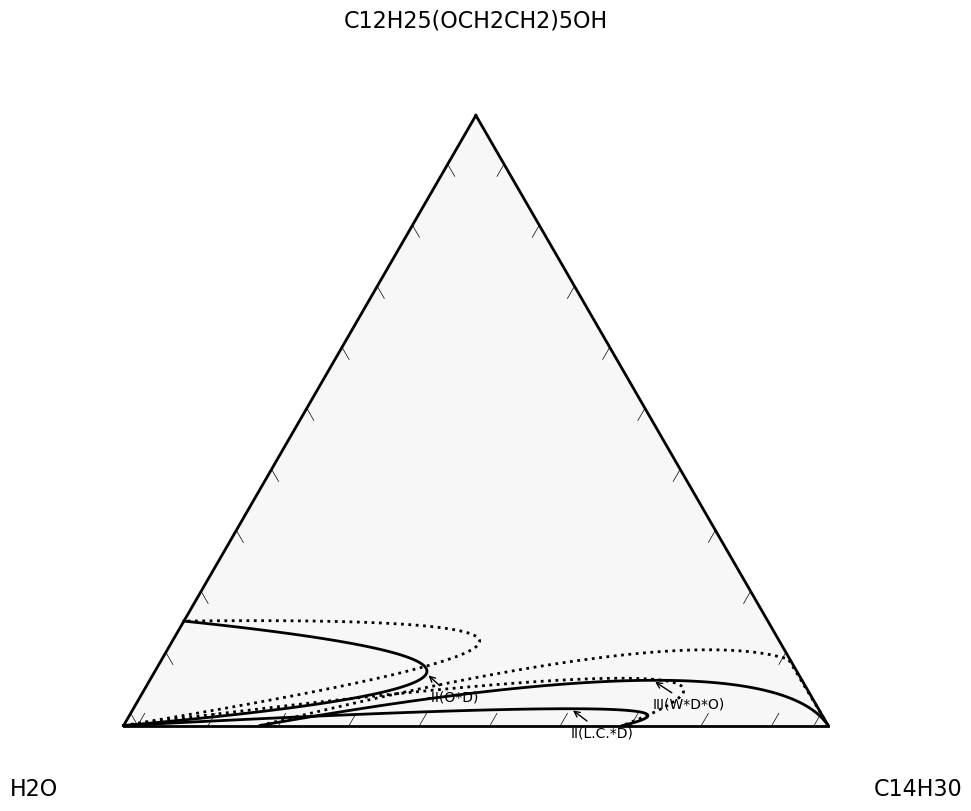

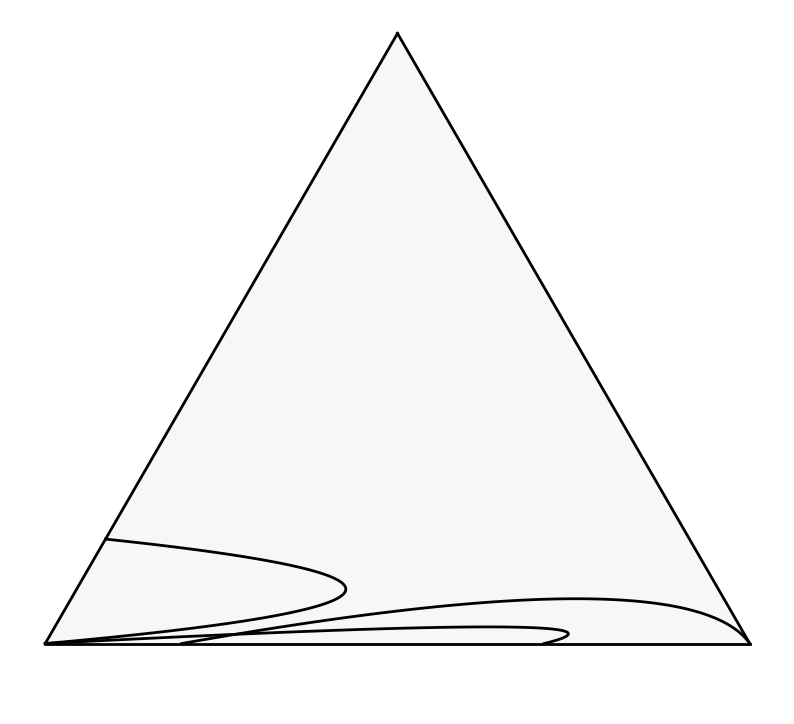

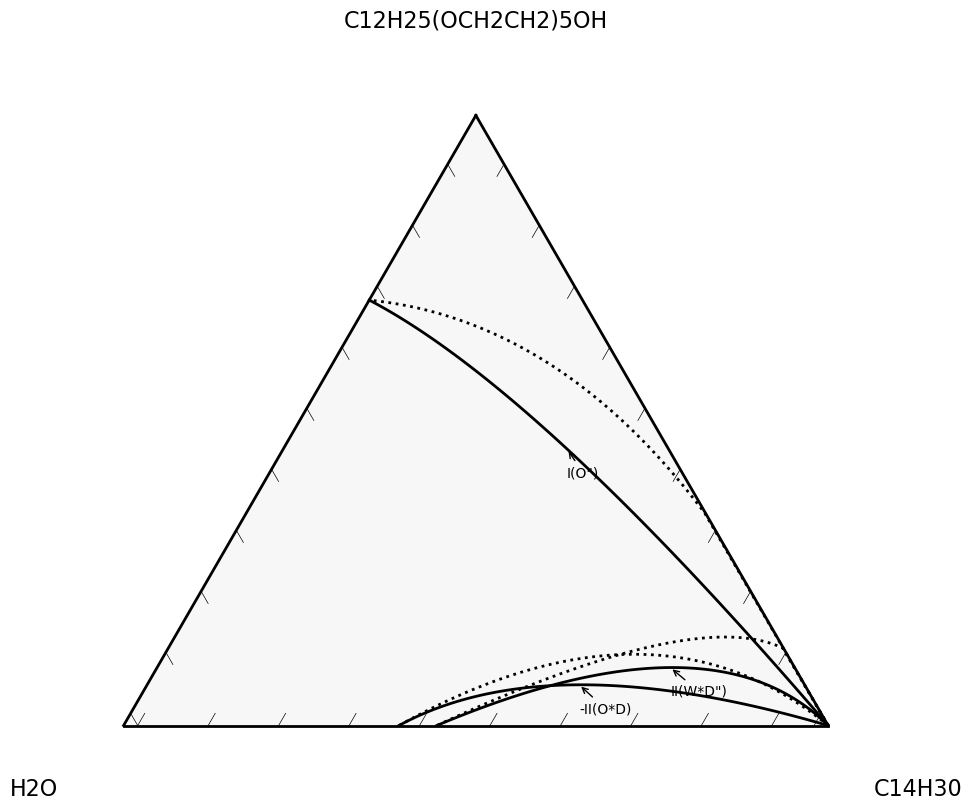

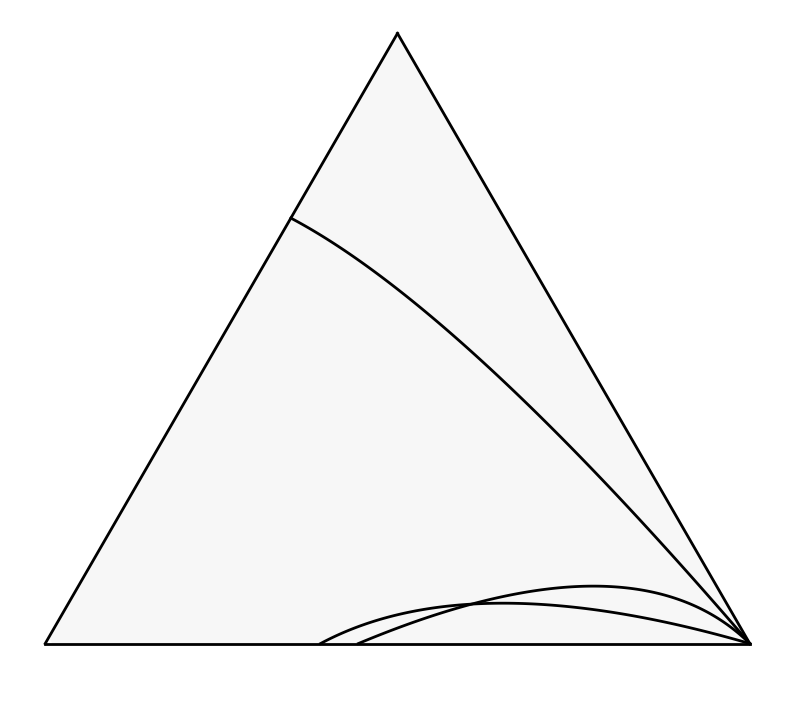

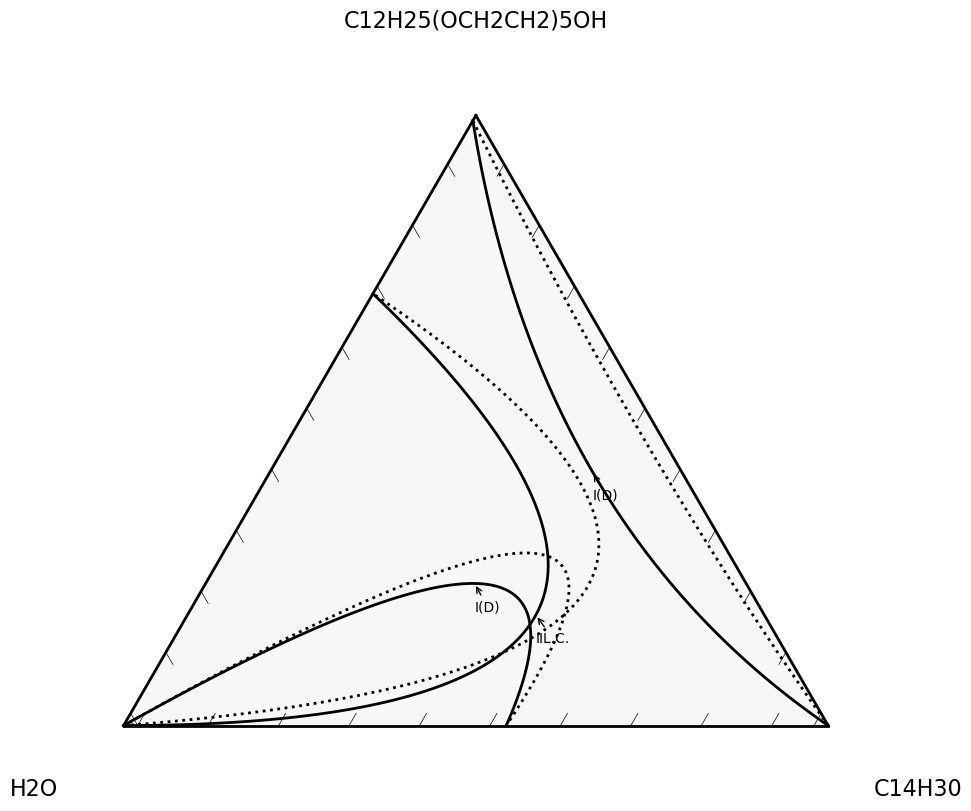

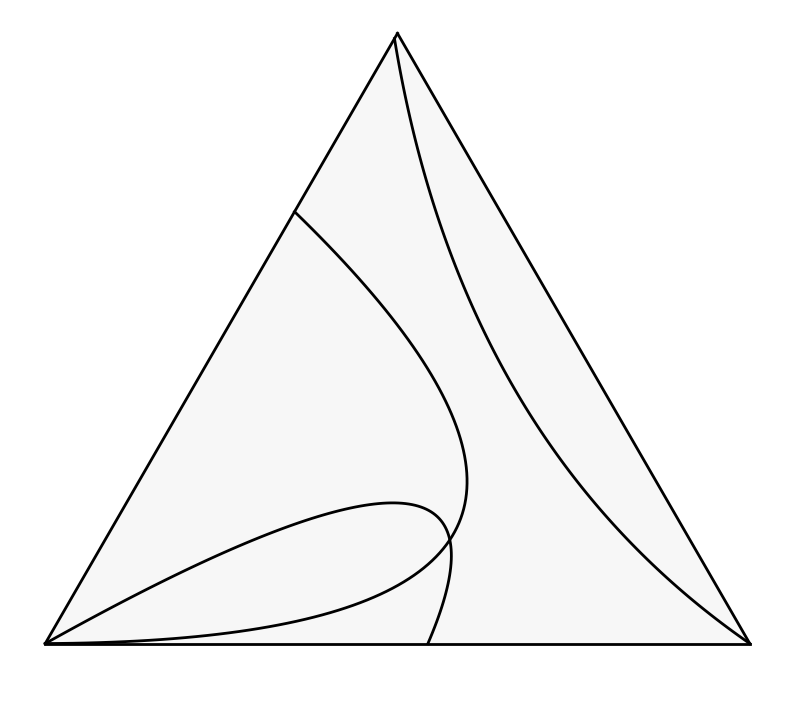

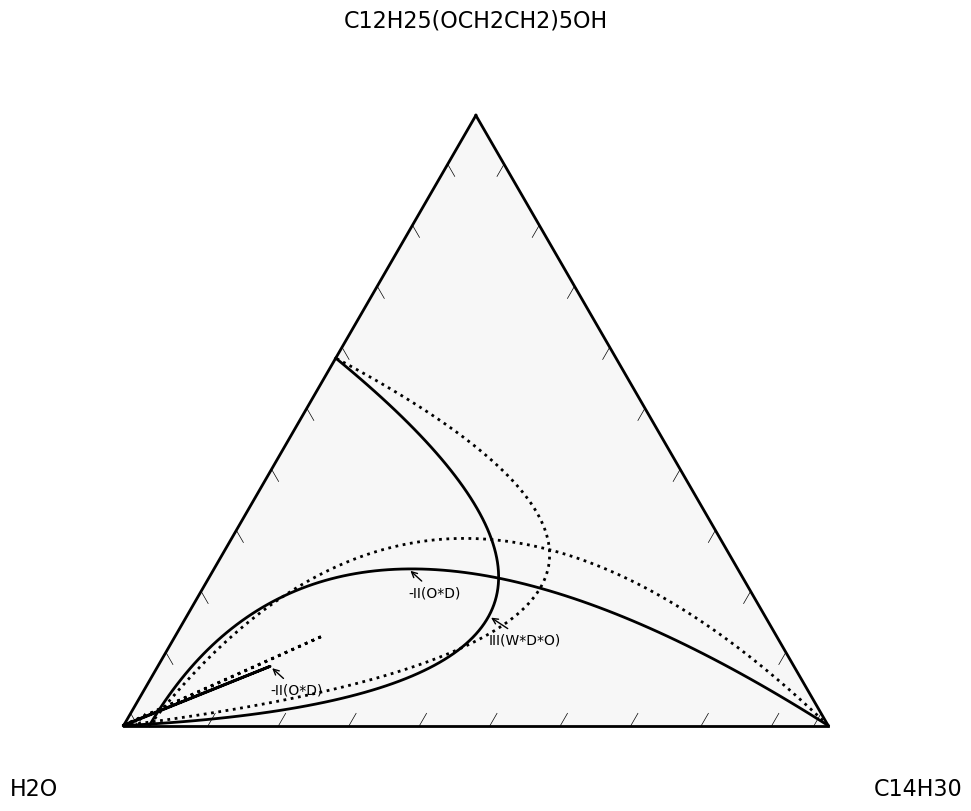

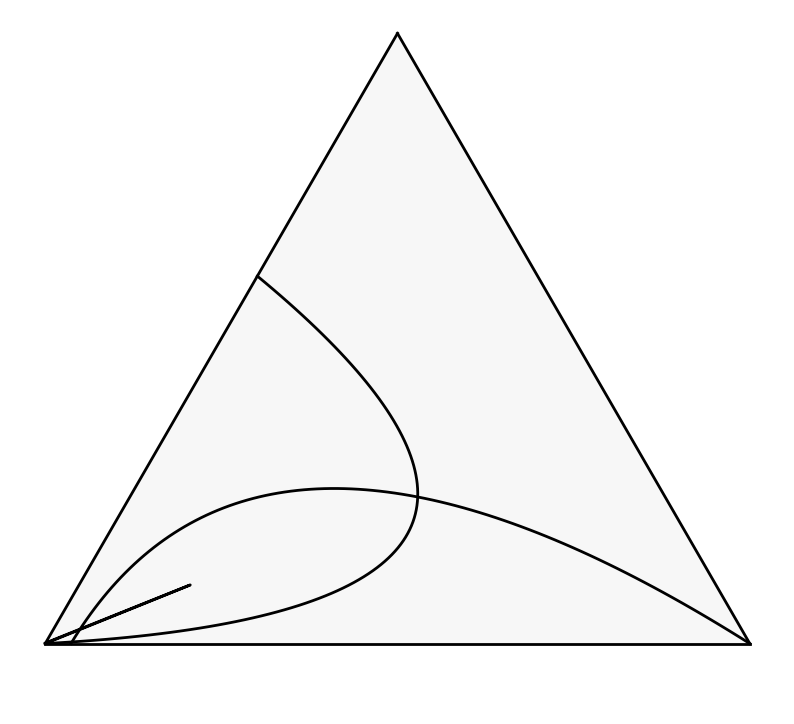

In [16]:
import ternary
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import comb
import os

# Define image_vertices globally
image_vertices = []

# Function to convert ternary coordinates to image coordinates
def ternary_to_image_coordinates(point, img_size, margins):
    # Unpack the point
    x, y = point

    # Unpack the image size and margins
    img_width, img_height = img_size
    margin_left, margin_right, margin_top, margin_bottom = margins

    # Compute the plot width and height
    plot_width = img_width - margin_left - margin_right
    plot_height = img_height - margin_top - margin_bottom

    # Convert the point to image coordinates
    img_x = margin_left + x * plot_width
    img_y = margin_top + (1 - y) * plot_height  # The y-coordinate is flipped because image coordinates start from the top

    return int(img_x), int(img_y)

# Modified function that checks if a point is inside the triangle
def point_in_triangle(point):
    global image_vertices  # Access the global variable
    # Define the vertices of the triangle
    triangle_vertices = np.array(image_vertices, dtype=np.int32)

    x, y = point
    if x < triangle_vertices[1,0] or x > triangle_vertices[2,0] or y < triangle_vertices[0,1] or y > triangle_vertices[1,1]:
        return False
    else:
        return True

# Function to create a Bezier curve
def bezier_curve(points, n=100):
    N = len(points)
    t = np.linspace(0, 1, num=n)

    curve = np.zeros((n, 2))
    for i in range(N):
        curve += np.outer(comb(N - 1, i) * (1 - t) ** (N - 1 - i) * t ** i, points[i])

    return curve

# Function to offset control points
def offset_control_points(points, offset=10):
    offset_points = np.copy(points)

    # Apply the offset to middle control point(s)
    for i in range(1, len(points) - 1):
        x, y = points[i]

        # Determine the closest edge: bottom (x-axis), left (y-axis), or right (y = 100 - x)
        dist_bottom = y
        dist_left = x
        dist_right = x + y - 100

        closest_edge = np.argmin([dist_bottom, dist_left, dist_right])

        if closest_edge == 0:  # Bottom edge
            offset_points[i, 1] -= offset
        elif closest_edge == 1:  # Left edge
            offset_points[i, 0] -= offset
        else:  # Right edge
            offset_points[i] += offset

    return offset_points

# Function to create the ternary plot
def create_ternary_plot(plot_type="input", control_points_list=None, save_folder="plots", unique_id="1"):
    global image_vertices  # Access the global variable
    
    # To this:
    fig, ax = plt.subplots(figsize=(10,10), dpi=100)  # Adjust figsize and dpi as needed
    ax.set_aspect('equal')  # This will ensure that the ternary diagram will not be distorted
   
    ax.fill([0, 0.5, 1, 0], [0, np.sqrt(3)/2, 0, 0], 'white', zorder=0)
    ax.axis('off') # Turn off the axes
    
    # Change the margins to be zero (you can adjust this later if you want some margins)
    margins = (0, 0, 0, 0)


    figure, tax = ternary.figure(scale=100, ax=ax) # Pass the axes to the ternary plot
    
    # Define the image size and margins
    img_size = (1000, 1000)  # This should match your actual image size
    margins = (50, 50, 50, 50)  # These should match your actual plot margins

    # Define the ternary diagram vertices
    ternary_vertices = [(0, 0), (1, 0), (0.5, np.sqrt(3)/2)]

    # Convert the vertices to image coordinates
    image_vertices = [ternary_to_image_coordinates(v, img_size, margins) for v in ternary_vertices]

    # Other parts remain unchanged...


    if plot_type == "input":
        # Set the labels for the compounds
        tax.left_axis_label("H2O", fontsize=16, offset=0.12, position=(-0.07, 0.0), rotation=0)
        tax.right_axis_label("C14H30", fontsize=16, offset=0.12, position=(1.07, 0.0), rotation=0)
        tax.boundary(linewidth=2.0)
        for side in ["left", "right", "bottom"]:
            tax.get_axes().spines[side].set_color('black')

        # Draw custom gridlines
        for i in range(2, 100, 10):  # Starting from 2 and not from 0 to avoid drawing over the edges
            # Bottom edge: lines pointing up
            tax.line((i, 0, 100-i), (i, 2, 100-i-2), linewidth=0.5, color='black', linestyle="-", zorder=1)

            # Left edge: lines pointing to the right
            tax.line((0, i, 100-i), (2, i-2, 100-i), linewidth=0.5, color='black', linestyle="-", zorder=1)

            # Right edge: lines pointing down
            tax.line((100-i, i, 0), (100-i, i-2, 2), linewidth=0.5, color='black', linestyle="-", zorder=1)

        # Define labels
        labels = ["II(L.C.*D)", "IIL.C.", "II(W*D\")", "I(O\")", "I(D(=O))", "I(D)", "III(W*D*O)", "-II(O*D)"]

    elif plot_type == "output":
        # Only show the triangle edges in the output plot
        tax.boundary(linewidth=2.0)
        for side in ["left", "right", "bottom"]:
            tax.get_axes().spines[side].set_color('black')

    # Draw curved phase lines
    num_curves = 3
    curves = []
    for i in range(num_curves):
        if control_points_list is None:  # Generate new control points
            control_points = np.random.rand(3, 2) * 100
            control_points[:, 1] = control_points[:, 1] * (100 - control_points[:, 0]) / 100

            # Ensure the first point is on the bottom left or right corner of the triangle
            if np.random.rand() < 0.5:
                control_points[0] = [0, 0]  # Bottom left corner
            else:
                control_points[0] = [100, 0]  # Bottom right corner

            # Ensure the last point is on a random edge of the triangle
            if np.random.rand() < 0.5:
                control_points[-1] = [np.random.rand() * 100, 0]  # Bottom edge
            else:
                control_points[-1] = [0, np.random.rand() * 100]  # Left edge
        else:  # Use provided control points
            control_points = control_points_list[i]

        # Generate the Bezier curve
        curve = bezier_curve(control_points)

        # Convert the curve points to ternary coordinates
        points = [(x, y, 100 - x - y) for x, y in curve if 100 - x - y >= 0]

        # Plot the solid line
        tax.plot(points, linewidth=2.0, color='black')  # Solid line

        curves.append(points)

        if plot_type == "input":
            # Offset the control points for the dotted line
            offset_control_pts = offset_control_points(control_points)

            # Generate the Bezier curve for the offset line
            offset_curve = bezier_curve(offset_control_pts)

            # Convert the curve points to ternary coordinates
            offset_points = [(x, y, 100 - x - y) for x, y in offset_curve if 100 - x - y >= 0]

            # Calculate the midpoint for the label
            midpoint = points[len(points)//2]

            # Randomly select a label
            label = np.random.choice(labels)

            # Add the label with a line pointing to the midpoint of the solid line
            tax.annotate(label, position=midpoint, xytext=(0, -20),
                         textcoords='offset points', arrowprops=dict(arrowstyle='->'), rotation=0)

            # Plot the offset dotted line
            tax.plot(offset_points, linewidth=2.0, color='black', linestyle=':')  # Dotted line

    if plot_type == "input":
        # Manually add the top label
        tax.ax.text(50, 100, "C12H25(OCH2CH2)5OH", ha='center', va='center', fontsize=16)

    # Remove the axes
    plt.gca().set_axis_off()


    # Save the plot to a file before showing it
    file_name = f"{unique_id}.png"
    save_path = os.path.join(save_folder, file_name)
    plt.savefig(save_path, dpi=300, bbox_inches='tight')


    # Show the plot
    plt.show()

    return control_points_list if control_points_list is not None else [np.array(c)[:, :2] for c in curves]


# Function to generate a unique ID in the format "input_plot_1", "output_plot_1", ...
def generate_unique_id(prefix, count_dict):
    if prefix not in count_dict:
        count_dict[prefix] = 1
    unique_id = f"{prefix}_plot_{count_dict[prefix]}"
    count_dict[prefix] += 1
    return unique_id



# Create the folder if it doesn't exist
save_folder = "plots"
os.makedirs(save_folder, exist_ok=True)

# Initialize the count dictionary
count_dict = {}

# Generate 10 sets of input and output plots
for i in range(10):
    unique_id = generate_unique_id("input", count_dict)
    control_points_list = create_ternary_plot("input", save_folder=save_folder, unique_id=unique_id)
    unique_id = generate_unique_id("output", count_dict)
    create_ternary_plot("output", control_points_list, save_folder=save_folder, unique_id=unique_id)



In [18]:
from PIL import Image

def get_image_size(image_path):
    with Image.open(image_path) as img:
        return img.size

# Use the function
image_path = "plots/output_plot_1.png"
width, height = get_image_size(image_path)
print(f"The image size is {width}x{height} pixels.")


The image size is 2385x2173 pixels.


The image size is 2916x2431 pixels.